## **[:+:] -- Registration & Alignment for Neuroimagery -- [:+:]** 

In [2]:
from pystackreg import StackReg
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import glob
import tifffile as tif
import numpy as np
import scipy.io 
from scipy.io import loadmat
import os 
import imageio 
import sys
import image_registration as imreg
import seaborn as sb
import pandas as pd
# print(sys.path)
#import cv2

# import sys
# print(sys.path)
# [+]- Load .MAT file, decide output directory of resulting TIFF files
matPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files') 
# matFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.mat")
refMouseFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNSx180_300.tiff")
samplePath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample")
tiffPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_files') 
tiffFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.tiff")
subStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks")
subStackPath1= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks\p1")
# subStackPath2= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks\secondHalf")
superStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks")
registeredPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered")
psr_avgFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg180_300.tiff")
unalignedFile180_300_refPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_refPrefix.tiff")
unalignedFile180_300_noPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_noPrefix.tiff")



## __[+]__ Functions

In [32]:
def tensorize(filename, beginDex=0):
    if os.path.isfile(filename):
        baseName = os.path.basename(filename)
        if baseName.endswith('.mat'): 
            print("\n[::] --- Fields of the MAT file: --- " + str(filename))
            filename= loadmat(filename)
            vTensor = filename['MouseData']
            print(filename.keys())
            print("Header: " + str(filename['__header__']))
            print("Version: " + str(filename['__version__']))
            print("Globals: " + str(filename['__globals__']))
            print("[::] --- Type and dimensions of MAT img data: ")
            print(type(vTensor))
            print((vTensor.shape))
            print("Elements of type: " + str(type(vTensor[0][0][0])))
            print((vTensor[0][0][0+beginDex]))
            print((vTensor[1][1][1+beginDex]))
            print((vTensor[2][2][2+beginDex]))
        elif baseName.endswith('.tiff'):
            print("\n[::] --- Type and dimensions of TIFF File: --- " + str(filename))
            filename= io.imread(filename)
            print(type(filename))
            shape= filename.shape
            print("Shape: " + str(shape))
            if len(shape)==3 :
                print("Elements of type: " + str(type(filename[0][0][0])))
                print((filename[0][0][0]))
                print((filename[1][1][1]))
                print((filename[2][2][2]))
            else: 
                print("Elements of type: " + str(type(filename[0][0])))
                print((filename[0][0]))
                print((filename[1][1]))
                print((filename[2][2]))
        else: print("\nInvalid File type, no tensorInfo")
    elif isinstance(filename, np.ndarray):
        print("\n[::] --- Type and dimensions of Tensor: --- " )
        shape= filename.shape
        print("Shape: " + str(shape))
        if len(shape)==3 :
            print("Elements of type: " + str(type(filename[0][0][0])))
            print((filename[0][0][0]))
            print((filename[1][1][1]))
            print((filename[2][2][2]))
        else: 
            print("Elements of type: " + str(type(filename[0][0])))
            print((filename[0][0]))
            print((filename[1][1]))
            print((filename[2][2]))
    else: print("\nNo tensorInfo, Invalid Input")



def mattotiff(matFile, outPath, beginDex=0, enDex=3600, showTensorInfo=False, addendum=""):
    matData= loadmat(matFile)
    vTensor = matData['MouseData']

    # [+]- Specify a subset of the video frame tensor
    vTensor= vTensor[:, :, beginDex:enDex]

    # [+]- Save 3d tensor as a tiff image stack, saves into current directory by default
    matBaseName = os.path.basename(matFile)
    tiffName = os.path.splitext(matBaseName)[0] + addendum+".tiff"
    output_filename = os.path.join(outPath, tiffName)
    tif.imsave(output_filename, vTensor, bigtiff=True)

    #[+]- Access the new  TIFF file, and makes sure its dimensions are proper
    if showTensorInfo:
        print("matFile: " + matFile)
        print("matBaseName: " + matBaseName)
        print("tiffName: " + tiffName)
        print("output_filename: " + output_filename)
        tensorize(matFile, beginDex)
        tensorize((output_filename, beginDex))
    return output_filename


def euclidistance(a, b):
    # Make sure a and b have the same shape
    assert a.shape == b.shape
    # Calculate the difference between the two arrays element-wise
    diff = a - b
    # [+] Euclidean distance = frobenius norm of the sum of squared differences
    distance = np.linalg.norm(diff)
    return distance

def slice_n_Dice(mat1, mat2):
    assert mat2.shape == mat1.shape
    intersection = np.sum(mat1 * mat2)
    union = np.sum(mat1) + np.sum(mat2)
    dice = (2 * intersection) / union
    return dice

def distanceMatrix(vTensor, fMatrix,  endex, begindex=0):
    eDists= np.empty(0)
    diceSims= np.empty(0)
    for i in range(begindex, endex):
        eDist= euclidistance((vTensor[:, :, i]), fMatrix)
        eDists= np.append(eDists, eDist)

        diceSim= slice_n_Dice((vTensor[:, :, i]), fMatrix)
        diceSims= np.append(diceSims, diceSim)

    return eDists, diceSims

## __[+]:.__ Process .MAT Reference Files

In [7]:
# [+]- Find the reference MAT file, convert it into a TIFF img stack, then extract the substack
#tiffRef= mat_to_tiff(matFile, outPath=samplePath, showTensorInfo= True)
# refFile100= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=100, showTensorInfo= True, addendum= "x100")
# refFile200= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=200, showTensorInfo= True, addendum= "x200")
# refFile300= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=300, showTensorInfo= True, addendum= "x300")
refFile180_300= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")

matFile: C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.mat
matBaseName: Norm_Mouse56_SNS.mat
tiffName: Norm_Mouse56_SNSx180_300.tiff
output_filename: C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNSx180_300.tiff

[::] --- Fields of the MAT file: --- C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.mat
dict_keys(['__header__', '__version__', '__globals__', 'MouseData'])
Header: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb  9 20:59:28 2023'
Version: 1.0
Globals: []
[::] --- Type and dimensions of MAT img data: 
<class 'numpy.ndarray'>
(128, 91, 3600)
Elements of type: <class 'numpy.float64'>
0.059528685330494144
0.0813145139079087
0.07965134171177135

[::] --- Type and dimensions of TIFF File: --- C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\norma

## **[+]** Convert Entire Directory .MAT ->.TIFF 

In [18]:
# Get a list of all files in the directory
matFiles = [f for f in os.listdir(matPath) if os.path.isfile(os.path.join(matPath, f))]
# Print the number of files
print(f"Number of files in directory '{matPath}': {len(matFiles)}")

# [+]- Iterate through directory of MAT files, converting each one into TIFF files:
for filename in matFiles:
    if filename.endswith('.mat'): 
        # print(filename)
        mattotiff(os.path.join(matPath, filename), outPath=tiffPath, beginDex=180, enDex=300, showTensorInfo= False, addendum= "x180_300")

Number of files in directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files': 82


#### __[+]__ Confirm Conversion

In [36]:
tiffFiles = [file for file in os.listdir(tiffPath) if os.path.isfile(os.path.join(tiffPath, file))]
print(f"Number of files in matPath directory '{matPath}': {len(matFiles)}")
print(f"Number of files in tiffPath directory '{tiffPath}': {len(tiffFiles)}")
for i in np.array([1,2,3,5,7,9]):
    print("\n[:::] ====================================================================================================================[::]")
    tensorize(os.path.join(matPath, matFiles[i]), beginDex= 180)
    tensorize(os.path.join(tiffPath, tiffFiles[i]), beginDex= 0)

Number of files in matPath directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files': 82
Number of files in tiffPath directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_files': 82

[:::] ====================================================================================================================[::]

[::] --- Fields of the MAT file: --- C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files\Norm_Mouse102_Stheta.mat
dict_keys(['__header__', '__version__', '__globals__', 'MouseData'])
Header: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb  9 20:54:59 2023'
Version: 1.0
Globals: []
[::] --- Type and dimensions of MAT img data: 
<class 'numpy.ndarray'>
(128, 91, 3600)
Elements of type: <class 'numpy.float64'>
0.0676950693157897
0.08363135231643903
0.07697382520269894

[::] --- Type and dimensions of TIFF File: --- C:\Users\richa\

## __[+]__ Tensor Compilation

In [50]:
#[:]- We create the registrar function, we choose rigid body for the alighment method
# registrar = StackReg(StackReg.RIGID_BODY)

#[:]- We read the reference stacks we created earlier , this is the stack that we us as reference 
refSubStack180_300= io.imread(refMouseFile)



#[:+]- Compile the Tensor to be aligned ----------------------------------------------------//
#[:]--- Put the reference substack in the right folder
tensorFrames= refSubStack180_300
#[:]--- Start with the reference frames, and append a directory of TIFF files onto it
for filename in glob.glob(subStackPath + '\*.tiff'):
    img= io.imread(filename)
    tensorFrames= np.concatenate((tensorFrames, img), axis=2)
    print( str(os.path.basename(filename))+ " ---> " + str(tensorFrames.shape))



#[:+]- Save the resulting unregistered tensor, will need later ----------------------------//
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_refPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames)

#[+]- Save a version WITHOUT the reference appended at the beginning, for different registration methods
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_noPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames[:, :, 120:])


unprefixed= io.imread(unalignedFile180_300_noPrefix)
prefixed= io.imread(unalignedFile180_300_refPrefix)



#[:+]- -----------Sanity Check ----------------------------------------------------//
#[:]- These should be equivalent:
tensorize(refMouseFile, beginDex= 0)
tensorize(prefixed[:, :, 0:120], beginDex= 0)

#[:]- These should be equivalent:
tensorize(prefixed[:, :, 120:], beginDex= 0)
tensorize(unprefixed, beginDex=0)

Norm_Mouse100_MKNSx180_300.tiff ---> (128, 91, 240)
Norm_Mouse102_Sthetax180_300.tiff ---> (128, 91, 360)
Norm_Mouse104_MKthetax180_300.tiff ---> (128, 91, 480)
Norm_Mouse105_Sthetax180_300.tiff ---> (128, 91, 600)
Norm_Mouse106_SNSx180_300.tiff ---> (128, 91, 720)
Norm_Mouse107_MKthetax180_300.tiff ---> (128, 91, 840)
Norm_Mouse108_Sthetax180_300.tiff ---> (128, 91, 960)
Norm_Mouse109_MKgammax180_300.tiff ---> (128, 91, 1080)
Norm_Mouse110_Sgammax180_300.tiff ---> (128, 91, 1200)
Norm_Mouse111_Sthetax180_300.tiff ---> (128, 91, 1320)
Norm_Mouse112_Sthetax180_300.tiff ---> (128, 91, 1440)
Norm_Mouse113_Sgammax180_300.tiff ---> (128, 91, 1560)
Norm_Mouse114_SNSx180_300.tiff ---> (128, 91, 1680)
Norm_Mouse115_SNSx180_300.tiff ---> (128, 91, 1800)
Norm_Mouse116_Sgammax180_300.tiff ---> (128, 91, 1920)
Norm_Mouse117_Sthetax180_300.tiff ---> (128, 91, 2040)
Norm_Mouse118_MKgammax180_300.tiff ---> (128, 91, 2160)
Norm_Mouse119_SNSx180_300.tiff ---> (128, 91, 2280)
Norm_Mouse120_Sthetax180_30

## __[+]__ Choose Referencing Method

In [5]:
registrar = StackReg(StackReg.RIGID_BODY)
unaligned180_300_refPrefix= io.imread(unalignedFile180_300_refPrefix)
unaligned180_300_noPrefix= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
# unaligned180_300_noPrefix= io.imread(unalignedFile180_300_noPrefix)

#### __[ ]__ Register to Previous Frame

In [44]:
#[:+:]--- -----------------------------------Choose Referencing Method  ------------------------------------------------------------------------------//
#[ ]-  this option registers each frame to the previous (already registered) one
out_previous = registrar.register_transform_stack(unaligned180_300_noPrefix, reference='previous')


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9960)
Elements of type: <class 'numpy.float64'>
0.06249763071537018
0.08087071776390076
0.07725615799427032


#### __[ ]__ Register to First Image

In [ ]:
#[ ]-  this option registers to first image:
out_first = registrar.register_transform_stack(unaligned180_300_noPrefix, reference='first')

#### __[ ]__ Register to the Total Mean

In [ ]:
#[ ]-  this option registers to mean image:
out_mean = registrar.register_transform_stack(unaligned180_300_noPrefix, reference='mean')

#### __[+]__ Register to Mean of First n images

In [6]:
# [+]-  this option registers to mean of first(300-180=120) images:
psr_avg180_300 = registrar.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)

#### __[ ]__ Register to Moving Average

In [ ]:
# calculate a moving average of 10 images, then register the moving average to the mean of
# the first 10 images and transform the original image (not the moving average)
out_moving10 = registrar.register_transform_stack(unaligned180_300_noPrefix, reference='first', n_frames=10, moving_average = 10)

In [7]:
# [:+:]---  Saving the results  --------------------------------------------------//
# [-]- To save the output to a tiff stack image, first convert float values to int
#   [+]- Actually doesn't seem necessary, float64 works
# psr_avg180_300 = psr_avg180_300.astype(np.int8)

# Using tifffile to save one of the image stacks into a single tif
alignedImgFile180_300= os.path.join(registeredPath,"psr_avg180_300.tiff")
tif.imsave(alignedImgFile180_300, psr_avg180_300)
rez= io.imread(alignedImgFile180_300)
tensorize(rez)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9960)
Elements of type: <class 'numpy.float64'>
0.06249763071537018
0.08087071776390076
0.07725615799427032


In [33]:
#unaligned180_300_noPrefix= io.imread(unalignedFile180_300_noPrefix)
unaligned180_300= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
psr_avgTensor= io.imread(psr_avgFile)[:, :, 120:]


refMean = np.mean(io.imread(refMouseFile), axis=2)
stdUnaligned= np.std(unaligned180_300, axis= 2)
std_psr_avgTensor= np.std(psr_avgTensor, axis= 2)
vLen= psr_avgTensor.shape[2]

#[:]-- Create the distance matrix
psr_refAvg_DM= (distanceMatrix(psr_avgTensor, refMean, endex=vLen, begindex= 0))
unaligned_DM= (distanceMatrix(unaligned180_300, refMean, endex=vLen, begindex= 0))
zeroD= (distanceMatrix(unaligned180_300, refMean, endex=vLen, begindex= 0))


In [42]:
# print(stdUnaligned)
print(unaligned180_300.shape)
print(psr_avgTensor.shape)


print(refMean.shape)
print(stdUnaligned.shape)
print(std_psr_avgTensor.shape)


print(psr_refAvg_DM[0])
print(psr_refAvg_DM[1])

(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
[7.1421683  7.16218448 7.17408564 ... 6.31648506 6.34206107 6.36578067]
[0.07735419 0.07760913 0.07771085 ... 0.09975669 0.09990174 0.10004461]


## __[ ]__ Data Viz

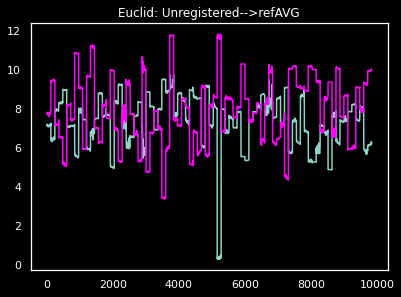

In [41]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .5


# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# plt.title('Euclid: Unregistered-->refAVG')
# sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0])
# plt.show()



# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# sb.lineplot(np.arange(vLen), psr_refAvg_DM[0])
# plt.title('Euclid: reg_ref-->refAvg')
# plt.show()

# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# sb.heatmap(data= stdUnaligned )
# plt.title('StdDev: Unaligned')
# plt.show()

# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# sb.heatmap(data= std_psr_avgTensor )
# plt.title('StdDev: reg_ref')
# plt.show()
# #-----------------------------------------------


# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# plt.title('Dice: Unregistered-->refAVG')
# sb.lineplot(np.arange(vLen), unaligned_DM[1],)
# plt.show()

# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# sb.lineplot(np.arange(vLen), psr_refAvg_DM[1],)
# plt.title('Dice: reg_ref-->refAvg')
# plt.show()

#---------------------------------------------

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Euclid: Unregistered-->refAVG')
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0], )
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[1]*100, color= 'magenta')
plt.show()





In [26]:



# def slice_n_Dice(mat1, mat2):
#     assert mat2.shape == mat1.shape[0]
#     diceArray= np.empty_like(mat1);
#     for i in range(mat1.shape[2]):
#         slice_ = mat1[:, :, i]
        # intersection = np.sum(slice_ * mat2)
        # union = np.sum(slice_) + np.sum(mat2)
        # dice = (2 * intersection) / union
#         diceArray[:,:,i] = slice_
#         # diceArray= np.concatenate([diceArray, np.expand_dims[matrix, 0]], axis=2)
#         # new_arr = np.concatenate([arr, np.expand_dims(mat, 0)], axis=0)
#     return diceArray




psr_avg_dice= (slice_n_Dice(psr_avgTensor[:, :, 0], refMean))
print(psr_avg_dice)


# for i in psr_avgTensor[0:, 0:, 120:]:
#     print(i.shape)




0.07735419263648825


## __[:::]__ ToDo

##### __[:+:]__--- Pre-processing ---
 - [+] Fix tiff files, they seem to be only 91x3600 instead of 91x128x3600
 - [+] Convert one ref MAT into TIFF
 - [+] Convert all 82 MATs into TIFFs
 - [+] Split single tiff file (sample) into first 100-300 frames
 - [+] Split whole data set into first 100-300 frames
 - [+] Change reference and substack to 180-300 frames
 - [+] save unaligned tiff 
##### __[::]__-- Alignment Algos (120-300) ---
 - [+] Pystackreg Align with reference avg
 - [ ] Pystackreg ALign with moving window size 10
 - [ ] image_registration alignment method
##### __[::]__-- Heuristics Functions ---
 - [x] Euclidian distance 
 - [x] Standard deviation
 - [x] Dice distance
 - [ ] Chi^2
 ##### __[::]__-- Data Viz ---
 - [+] Animate pystackreg registered


##### -[::]--- Misc ---
- [+] Make Repo
- [+] Form Functions
- [+] Fix tensorInfo fx
- [ ] Compare single images across different mice, and find the differences
- [ ] Create DataFrame for plotting